In [1]:
import numpy as np 
import pandas as pd 
import os
print(os.listdir("/kaggle/input/miniddsm"))

['Mini_DDSM_Upload']


In [2]:
infected = os.listdir('/kaggle/input/miniddsm/Mini_DDSM_Upload/Cancer') 
uninfected = os.listdir('/kaggle/input/miniddsm/Mini_DDSM_Upload/Normal')

In [3]:
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from PIL import Image
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import np_utils
import pywt

Using TensorFlow backend.


In [5]:
data = []
labels = []

for i in infected:
    try:
    
        image = cv2.imread("/kaggle/input/miniddsm/Mini_DDSM_Upload/Cancer/"+i)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        coeffs1 = pywt.dwt2(resize_img, 'bior1.3')
        LL, (LH, HL, HH) = coeffs1
        data.append(np.array(LL))
        data.append(np.array(LH))
        data.append(np.array(HL))
        data.append(np.array(HH))
        labels.append(1)
        labels.append(1)
        labels.append(1)
        labels.append(1)
        
    except AttributeError:
        print('Error')
    
for u in uninfected:
    try:
        
        image = cv2.imread("/kaggle/input/miniddsm/Mini_DDSM_Upload/Normal/"+u)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        coeffs2 = pywt.dwt2(resize_img, 'bior1.3')
        LL, (LH, HL, HH) = coeffs2
        data.append(np.array(LL))
        data.append(np.array(LH))
        data.append(np.array(HL))
        data.append(np.array(HH))
        labels.append(0)
        labels.append(0)
        labels.append(0)
        labels.append(0)
        
    except AttributeError:
        print('Error')

In [6]:
cells = np.array(data)
labels = np.array(labels)

np.save('Cells' , cells)
np.save('Labels' , labels)

In [7]:
print('Cells : {} | labels : {}'.format(cells.shape , labels.shape))

Cells : (25296, 50, 27, 4) | labels : (25296,)


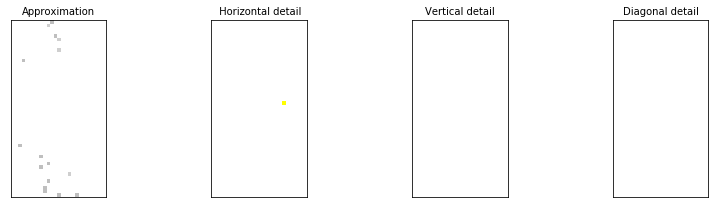

LL : (50, 27, 4) | LH : (50, 27, 4)


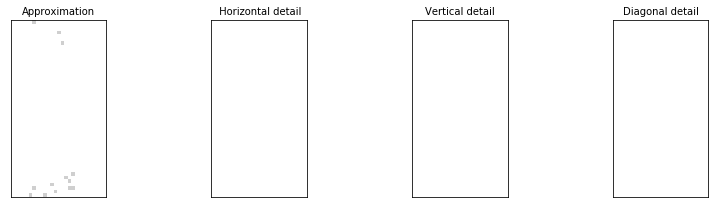

LL : (50, 27, 4) | LH : (50, 27, 4)


In [8]:
image1 = cv2.imread("/kaggle/input/miniddsm/Mini_DDSM_Upload/Cancer/1000_A_1105_1.LEFT_CC.LJPEG.1_highpass.png")
image2 = cv2.imread("/kaggle/input/miniddsm/Mini_DDSM_Upload/Normal/1000_A_0358_1.RIGHT_CC.LJPEG.1_highpass.png")
images=[image1,image2]
for image in images:
    image_array = Image.fromarray(image , 'RGB')
    resize_img = image_array.resize((50 , 50))
    coeffs2 = pywt.dwt2(resize_img, 'bior1.3')
    LL, (LH, HL, HH) = coeffs2
    fig = plt.figure(figsize=(12, 3))
    # Wavelet transform of image, and plot approximation and details
    titles = ['Approximation', ' Horizontal detail','Vertical detail', 'Diagonal detail']
    for i, a in enumerate([LL, LH, HL, HH]):
        ax = fig.add_subplot(1, 4, i + 1)
        ax.imshow(a,  interpolation="nearest",cmap=plt.cm.gray)
        ax.set_title(titles[i], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

    fig.tight_layout()
    plt.show()
    print('LL : {} | LH : {}'.format(LL.shape , LH.shape))

In [9]:
n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]

In [10]:
cells = cells.astype(np.float32)
labels = labels.astype(np.int32)
cells = cells/255

In [12]:
from sklearn.model_selection import train_test_split

x_train , x , y_train , y = train_test_split(cells , labels , 
                                            test_size = 0.2 ,
                                            random_state = 11)

x_eval ,x_test ,y_eval , y_test = train_test_split(x , y , 
                                                    test_size = 0.5 , 
                                                    random_state = 11)

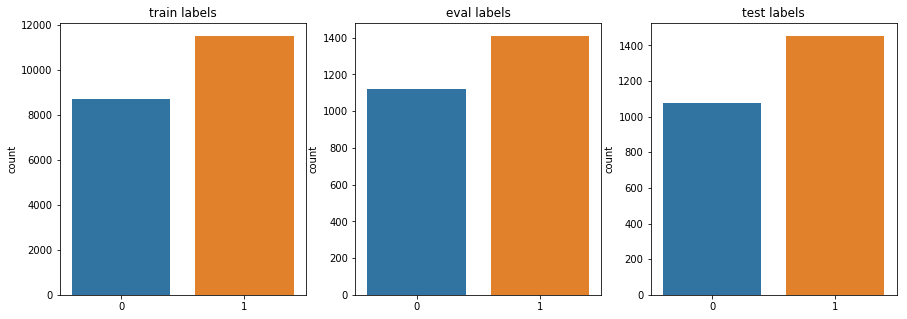

In [13]:
import seaborn as sns
plt.figure(1 , figsize = (15 ,5))
n = 0 
for z , j in zip([y_train , y_eval ,y_test] , ['train labels','eval labels','test labels']):
    n += 1
    plt.subplot(1 , 3  , n)
    sns.countplot(z)
    plt.title(j)
plt.show()

In [14]:
y_train = np_utils.to_categorical(y_train, num_classes = 2)
y_eval = np_utils.to_categorical(y_eval, num_classes = 2)
y_test = np_utils.to_categorical(y_test, num_classes = 2)

In [15]:
print(f'SHAPE OF TRAINING IMAGE DATA : {x_train.shape}')
print(f'SHAPE OF TRAINING LABELS : {y_train.shape}')

print(f'SHAPE OF EVALUATION IMAGE DATA : {x_eval.shape}')
print(f'SHAPE OF EVALUATION LABELS : {y_eval.shape}')

print(f'SHAPE OF TESTING IMAGE DATA : {x_test.shape}')
print(f'SHAPE OF TESTING LABELS : {y_test.shape}')

SHAPE OF TRAINING IMAGE DATA : (20236, 50, 27, 4)
SHAPE OF TRAINING LABELS : (20236, 2)
SHAPE OF EVALUATION IMAGE DATA : (2530, 50, 27, 4)
SHAPE OF EVALUATION LABELS : (2530, 2)
SHAPE OF TESTING IMAGE DATA : (2530, 50, 27, 4)
SHAPE OF TESTING LABELS : (2530, 2)


In [15]:
import keras
from keras.layers import Dense, Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Sequential
from keras import backend as K

from keras import optimizers

In [ ]:
def CNNbuild(height, width, classes, channels):
    model = Sequential()
    
    inputShape = (height, width, channels,)
    chanDim = -1
    
    if K.image_data_format() == 'channels_first':
        inputShape = (channels, height, width)
    model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Flatten())
    
    model.add(Dense(512, activation = 'relu'))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation = 'softmax'))
    
    return model

In [ ]:
#instantiate the model
height = 50
width = 27
classes = 2
channels = 4
model = CNNbuild(height = height, width = width, classes = classes, channels = channels)
model.summary()

In [ ]:
#compile the model
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [ ]:
#fit the model onto the dataset
h = model.fit(x_train, y_train, epochs = 20, batch_size = 32,validation_data=(x_eval,y_eval),shuffle=True)

In [ ]:
plt.figure(figsize = (18,8))
plt.plot(range(20), h.history['acc'], label = 'Training Accuracy')
plt.plot(range(20), h.history['loss'], label = 'Taining Loss')
#ax1.set_xticks(np.arange(0, 31, 5))
plt.xlabel("Number of Epoch's")
plt.ylabel('Accuracy/Loss Value')
plt.title('Training Accuracy and Training Loss')
plt.legend(loc = "best")

# ax2.plot(range(20), h.history['loss'], label = 'Training Loss')
# ax2.plot(range(20), h.history['val_loss'], label = 'Validation Loss')
# #ax2.set_xticks(np.arange(0, 31, 5))
# ax2.set_xlabel("Number of Epoch's")
# ax2.set_ylabel('Loss Value')
# ax2.set_title('Training Loss vs Validation Loss')
# ax2.legend(loc = "best")

In [ ]:
#evaluate the model on test data
predictions = model.evaluate(x_test, y_test)
evaluation = model.evaluate(x_eval, y_eval)

In [ ]:
print(f'LOSS : {evaluation[0]}')
print(f'ACCURACY : {evaluation[1]}')
print(f'LOSS : {predictions[0]}')
print(f'ACCURACY : {predictions[1]}')